In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans

df = pd.read_parquet("1.parquet")
print(df.head())

   VendorID lpep_pickup_datetime lpep_dropoff_datetime   trip_duration  \
0         2  2020-01-01 00:41:38   2020-01-01 00:52:49 0 days 00:11:11   
1         2  2020-01-01 00:10:18   2020-01-01 00:22:16 0 days 00:11:58   
2         2  2020-01-01 01:03:14   2020-01-01 01:29:45 0 days 00:26:31   
3         2  2020-01-01 00:04:11   2020-01-01 00:09:48 0 days 00:05:37   
4         2  2020-01-01 00:25:52   2020-01-01 00:32:16 0 days 00:06:24   

  day_of_week  hour_of_day store_and_fwd_flag  RatecodeID  PULocationID  \
0   Wednesday            0                  N         1.0           181   
1   Wednesday            0                  N         1.0            25   
2   Wednesday            1                  N         1.0           225   
3   Wednesday            0                  N         1.0           129   
4   Wednesday            0                  N         1.0           129   

   DOLocationID  ...  mta_tax  tip_amount  tolls_amount  \
0           228  ...      0.5        3.54    

# 5.1. Predictive Analytics: Revenue Forecasting (XGBoost)

In [2]:
df['day_of_week'] = pd.Categorical(df['day_of_week']).codes
df['payment_type'] = pd.Categorical(df['payment_type']).codes

features = ['trip_distance', 'hour_of_day', 'day_of_week', 'payment_type']
target = 'total_amount'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [4]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

In [5]:
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.359051650850599
Mean Squared Error: 9.627680076308796
Root Mean Squared Error: 3.1028503148409845


# 5.2. Customer Segmentation (K-Means Clustering)

In [6]:
clustering_features = ['trip_distance', 'fare_amount', 'payment_type']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[clustering_features])

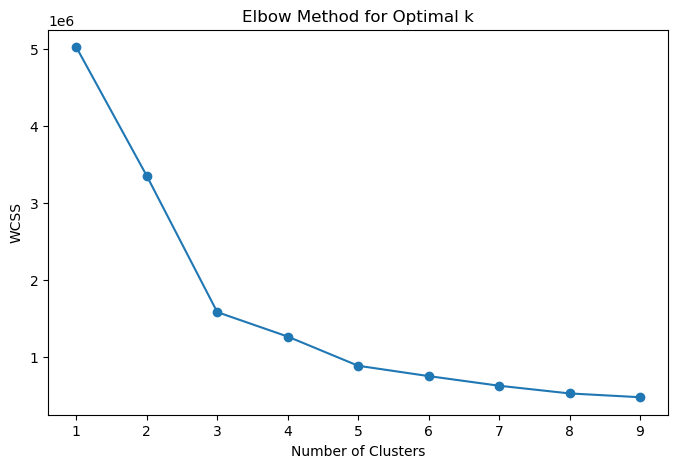

In [7]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


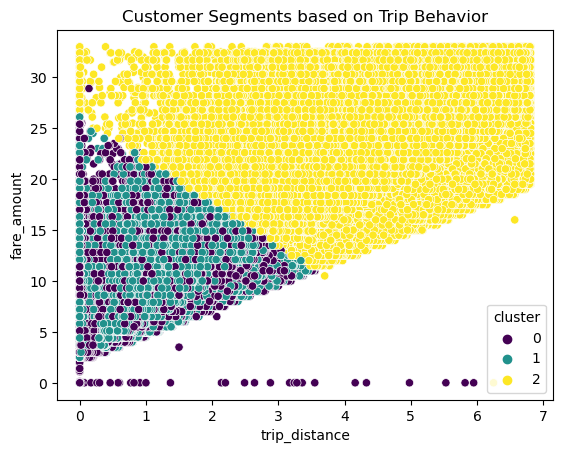

In [8]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

sns.scatterplot(x=df['trip_distance'], y=df['fare_amount'], hue=df['cluster'], palette='viridis')
plt.title('Customer Segments based on Trip Behavior')
plt.show()

# 5.3. Dynamic Pricing Optimization

In [9]:
def dynamic_pricing(hour, demand_factor, base_fare):
    peak_hours = [6, 7, 8, 15, 16, 17]
    if hour in peak_hours:
        surge_multiplier = 1.5  
    else:
        surge_multiplier = 1.0 
    
    adjusted_fare = base_fare * surge_multiplier * demand_factor
    return round(adjusted_fare, 2)

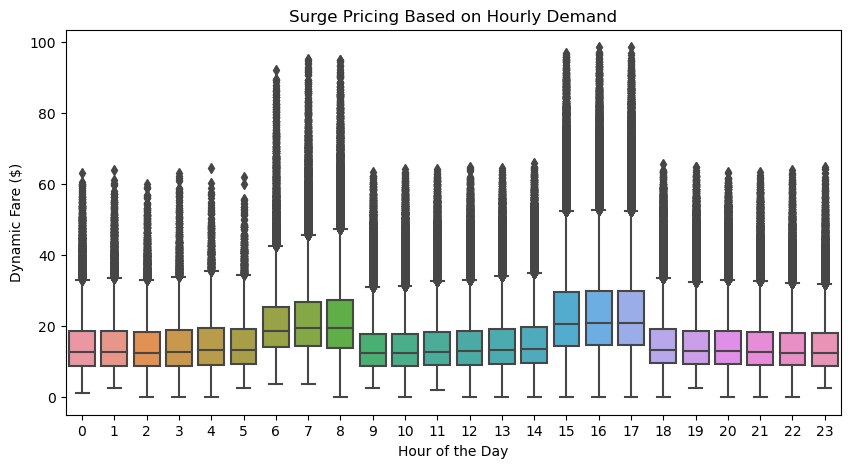

In [10]:
df['dynamic_fare'] = df.apply(lambda row: dynamic_pricing(row['hour_of_day'], np.random.uniform(1.0, 2.0), row['fare_amount']), axis=1)

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['hour_of_day'], y=df['dynamic_fare'])
plt.xlabel("Hour of the Day")
plt.ylabel("Dynamic Fare ($)")
plt.title("Surge Pricing Based on Hourly Demand")
plt.show()